In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from evallm.enumerate_dfa.enumerate import unpack_dfa
from evallm.experiments.exhaustive_transducer_experiment import (
    exhaustive_gpt_4o_mini,
    exhaustive_llama,
    exhaustive_gpt_4o_mini_red_green,
)
from evallm.experiments.exhaustive_transducer_analysis import (
    compute_all_summary_stats,
    plot_comparison,
    res_nan_bad,
    plot_correlations,
)
from evallm.experiments.render_dfa import render_pdfas

In [4]:
summaries = {}
for model, res in [
    ("4o-mini", exhaustive_gpt_4o_mini(1)),
    ("l3-8b", exhaustive_llama(1)),
    ("4o-mini-rg", exhaustive_gpt_4o_mini_red_green(1)),
]:
    summaries[model] = {k: v[0] for k, v in res.items() if v[0] is not None}

In [5]:
pdfas, ngram, no_nan, nan_bad = compute_all_summary_stats(summaries)

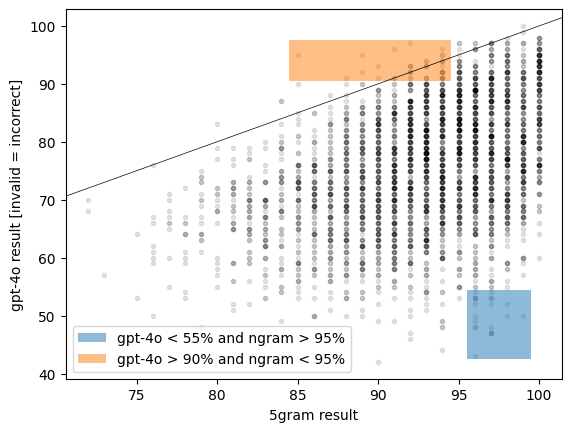

In [6]:
masks_gpt = plot_comparison(
    ngram,
    nan_bad["4o-mini"],
    "5gram result",
    "gpt-4o result [invalid = incorrect]",
    {
        "gpt-4o < 55% and ngram > 95%": lambda x, y: (x > 95) & (y < 55),
        "gpt-4o > 90% and ngram < 95%": lambda x, y: (x < 95) & (y > 90),
    },
)

In [7]:
# for label in masks_gpt:
#     render_pdfas([pdfas[i] for i in np.where(masks_gpt[label])[0]], label)
#     plt.show()

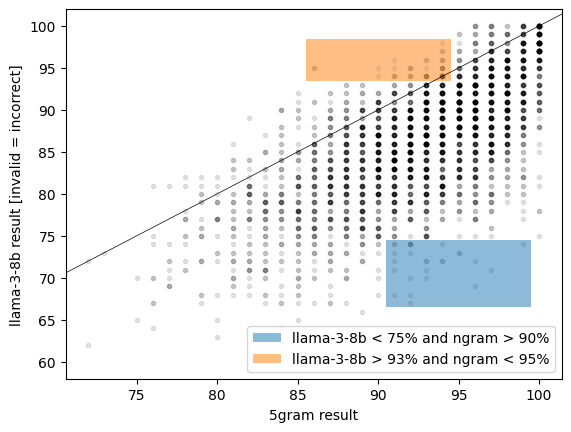

In [8]:
masks_llama = plot_comparison(
    ngram,
    nan_bad["l3-8b"],
    "5gram result",
    "llama-3-8b result [invalid = incorrect]",
    {
        "llama-3-8b < 75% and ngram > 90%": lambda x, y: (x > 90) & (y < 75),
        "llama-3-8b > 93% and ngram < 95%": lambda x, y: (x < 95) & (y > 93),
    },
)

In [9]:
# for label in masks_llama:
#     render_pdfas([pdfas[i] for i in np.where(masks_llama[label])[0]], label)
#     plt.show()

In [10]:
# import tqdm.auto as tqdm
# from collections import Counter
# from evallm.sample_dfa.sample_dfa import sample_dfa
# from evallm.enumerate_dfa.pack_dfa import pack_dfa


# def distribution_of_dfas(count):
#     return Counter(
#         pack_dfa(
#             sample_dfa(
#                 dict(type="sample_reachable_dfa", n_states=3, n_symbols=3),
#                 np.random.RandomState(i),
#             )
#         )
#         for i in tqdm.trange(count)
#     )

In [11]:
# c = distribution_of_dfas(10_000)

In [12]:
# distro = np.array([c[pdfa] for pdfa in pdfas])

In [13]:
# _ = plot_comparison(
#     nan_bad["llama-3-8b"],
#     nan_bad["gpt-4o-mini"],
#     "llama-3-8b result [invalid = incorrect]",
#     "gpt-4o result [invalid = incorrect]",
# )

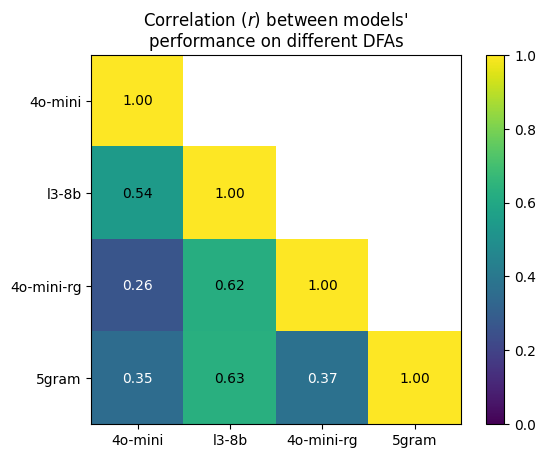

In [14]:
plot_correlations({**no_nan, "5gram": ngram})

In [15]:
result_all = {
    k: [v for v in vs if v is not None] for k, vs in exhaustive_llama(None).items()
}
result_all = {k: vs for k, vs in result_all.items() if vs}

In [16]:
mean_score = [np.min([res_nan_bad(x) for x in result_all[pdfa]]) for pdfa in result_all]

In [17]:
pdfas = list(result_all)
pdfas = [pdfas[i] for i in np.argsort(mean_score)]

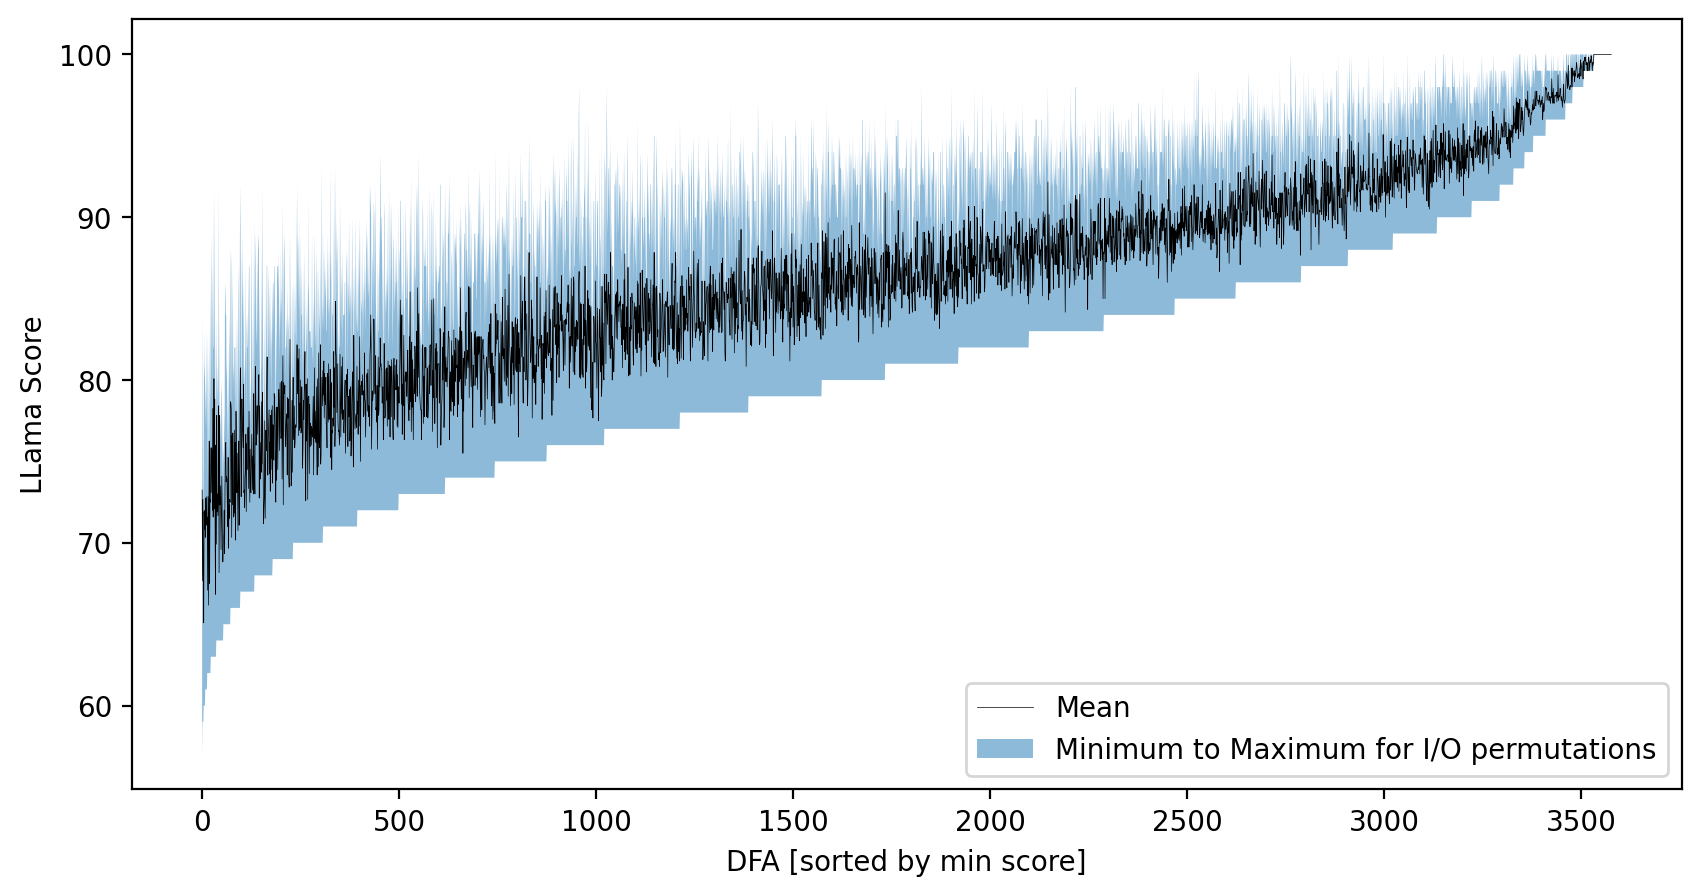

In [18]:
plt.figure(dpi=200, figsize=(10, 5))
plt.plot(
    np.arange(len(pdfas)),
    [
        np.mean([res_nan_bad(x) for x in result_all[pdfa] if x is not None])
        for pdfa in pdfas
    ],
    lw=0.25,
    color="black",
    label="Mean",
)
plt.fill_between(
    np.arange(len(pdfas)),
    [
        np.min([res_nan_bad(x) for x in result_all[pdfa] if x is not None])
        for pdfa in pdfas
    ],
    [
        np.max([res_nan_bad(x) for x in result_all[pdfa] if x is not None])
        for pdfa in pdfas
    ],
    alpha=0.5,
    label="Minimum to Maximum for I/O permutations",
)
plt.xlabel("DFA [sorted by min score]")
plt.ylabel("LLama Score")
plt.legend()
plt.show()